<a href="https://colab.research.google.com/github/Jungin1020/Aiffel/blob/main/2022_03_14_exp_17_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN

Generator 와 Discriominator 두 신경망이 minimax game을 통해 경쟁하며 발전

 판별자가 진짜 이미지라고 속게하려면 분류기 만들 때처럼 피처를 뽑아내는게 필요하지 않을까? (컨볼루션~)

 100점은 아니더라도 8~90점을 받을 수 있는 이미지

판별자는 어떻게 구분을 하는 걸까

노이즈가 아니라 특정 이미지이면 어떻게 생성이 될까?

조건 있는 생성모델 Conditional Generative Model

cGAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-datasets

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


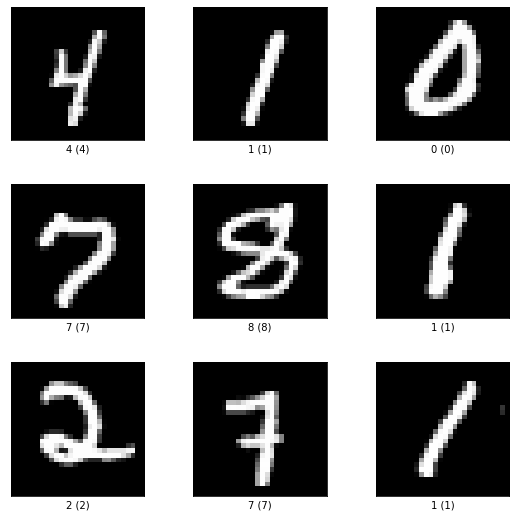

In [ ]:
import tensorflow_datasets as tfds

mnist, info = tfds.load('mnist', split='train', with_info=True)

fig = tfds.show_examples(mnist, info)

In [ ]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

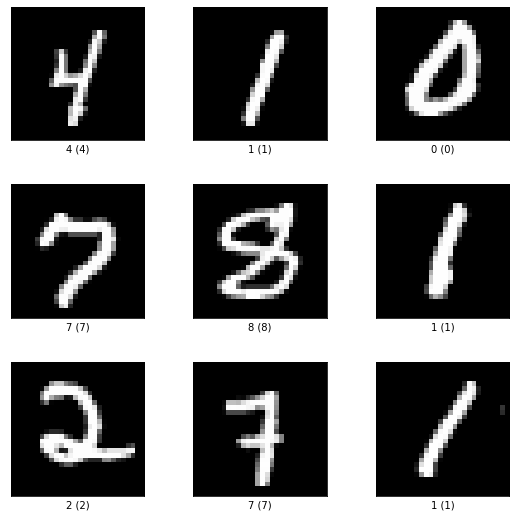

In [ ]:
fig

이미지 픽셀 값을 -1~1 사이로 변경

레이블 정보를 원핫인코딩

In [ ]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
  image = data['image']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  return image

def cgan_preprocessing(data):
  image = data['image']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1

  label = tf.one_hot(data['label'],10)
  return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)



정확히 처리되었는지 확인

label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
image min/max : -1.0 1.0


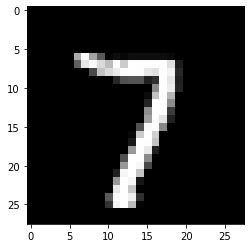

In [ ]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break #이거 좀 특이한데? 랜덤한 1개의 데이터 확인할 때

print('label :', j[0])
print('image min/max :', i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

###Generator를 만들자구~

tf2의 subclassing 방법으로!

Subclassing은 tensorflow.keras.Model을 상속받아 클래스를 만들며,

일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고,

구성된 레잉어를 call() 메서드를 이용해 forward propagation 진행

(파이토치와 비슷하므로 숙지하도록~)


In [ ]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
  def __init__(self):
    super(GeneratorGAN, self).__init__()

    self.dense_1 = layers.Dense(128, activation='relu')
    self.dense_2 = layers.Dense(256, activation='relu')
    self.dense_3 = layers.Dense(512, activation='relu')
    self.dense_4 = layers.Dense(28*28*1, activation='tanh')

    self.reshape = layers.Reshape((28,28,1))

  def call(self, noise):
    out = self.dense_1(noise)
    out = self.dense_2(out)
    out = self.dense_3(out)
    out = self.dense_4(out)
    return self.reshape(out)
    

###cGAN Generator
GAN에서 레이블 정보 추가

1. noise 와 label 에 각각 dense 적용
2. 1번의 결과가 서로 연결(concat)되어 다시 한번 dense
3. 2번 결과가 dense 거치고 28x28 차원의 결과가 생성 > (28,28,1)로 변환

In [ ]:
class GeneratorCGAN(Model):
  def __init__(self):
    super(GeneratorCGAN, self).__init__()

    self.dense_z = layers.Dense(256, activation='relu')
    self.dense_y = layers.Dense(256, activation='relu')
    self.combined_dense = layers.Dense(512, activation='relu')
    self.final_dense = layers.Dense(28*28*1, activation='tanh')
    self.reshape = layers.Reshape((28,28,1))

  def call(self, noise, label):
    noise = self.dense_z(noise)
    label = self.dense_y(label)
    out = self.combined_dense(tf.concat([noise, label], axis=-1))
    out = self.final_dense(out)

    return self.reshape(out)

###Discriminator를 만들자구~

for loop를 이용하여 간단하게!

DIscriminator 입력은 Generator가 생성한 (28,28,1)

이를 학습하기 위해 Flatten

마지막 dense 레이어를 통과하면 진짜 가짜 이미지를 나타내는 1개의 값이 출력

In [ ]:
class DiscriminatorGAN(Model):
  def __init__(self):
    super(DiscriminatorGAN, self).__init__()
    self.flatten = layers.Flatten()

    self.blocks = []
    for f in [512, 216, 128, 1]:
      self.blocks.append(layers.Dense(f, activation =None if f==1 else 'relu'))

  def call(self, x):
    x = self.flatten(x)
    for block in self.blocks:
      x = block(x)
    return x

Maxout은 Dropout 효과를 극대화하기 위한 독특한 형태의 활성화함수

두 레이어 사이를 연결할 때,

여러개의 desne 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 한다

In [ ]:
class Maxout(layers.Layer):
  def __init__(self, units, pieces):
    super(Maxout, self).__init__()
    self.dense = layers.Dense(units*pieces, activation='relu')
    self.dropout =layers.Dropout(.5)
    self.reshape = layers.Reshape((-1, pieces, units))

  def call(self, x):
    x = self.dense(x)
    x = self.dropout(x)
    x = self.reshape(x)
    return tf.math.reduce_max(x, axis=2)
    

maxout 에는 units와 pieces의 설정이 필요하다

예를 들어 units=100, pieces=10이면 100차원의 representation(wx+b)을 10개 만들고

그 중 최댓값을 가져와 최종 1개의 100차원 representation이 출력

In [ ]:
class DiscriminatorCGAN(Model):
  def __init__(self):
    super(DiscriminatorCGAN, self).__init__()
    self.flatten = layers.Flatten()

    self.image_block = Maxout(240,5)
    self.label_block = Maxout(50,5)
    self.combine_block = Maxout(240,4)

    self.dense = layers.Dense(1, activation=None)

  def call(self, image, label):
    image = self.flatten(image)
    image = self.image_block(image)
    label = self.label_block(label)
    x = layers.Concatenate()([image, label])
    x = self.combine_block(x)
    return self.dense(x)


GAN과 비슷한 구조

이미지와 라벨 입력 각각 Maxout 레이어를 한번씩 통과한 후 concat 하고 한번 더 Maxout

마지막으로 dense 통과하면 진짜 가짜 이미지를 나타내는 1개 값 출력

###학습 및 테스트

위에 만든 생성자, 판별자로 MNIST 학습하고 GAN, cGAN으로 손글씨 생성해보자

진짜 가짜를 구별하기 위해 Binary Cross Entropy 사용

Optimizer는 Adam

In [ ]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
  return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
  return bce(tf.ones_like(real_output),real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

입력으로 사용되는 노이즈 100차원

하나의 배치 크기 데이터로 모델을 업데이트하는 함수

In [ ]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
  noise = tf.random.normal([real_images.shape[0], 100])

  with tf.GradientTape(persistent=True) as tape:
    fake_images = gan_generator(noise)#Generator를 이용해 가짜 이미지 생성
    
    real_out = gan_discriminator(real_images)
    fake_out = gan_discriminator(fake_images)#Discriminator를 이용해 진짜가짜 이미지 판별

    gene_loss = generator_loss(fake_out)
    disc_loss = discriminator_loss(real_out, fake_out) #각 손실을 계산
  
  gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
  disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables) #gradient 계산

  gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
  disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))

  return gene_loss, disc_loss








100번의 반복마다 손실 출력

In [ ]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
  for i ,images in enumerate(gan_datasets):
    gene_loss, disc_loss = gan_step(images)

    if (i+1) % 100 == 0:
      print(f'[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}')

[1/10 EPOCHS, 100 ITER] G:2.2490482330322266, D:0.1295279860496521
[1/10 EPOCHS, 200 ITER] G:2.4905357360839844, D:0.10895193368196487
[1/10 EPOCHS, 300 ITER] G:2.0985326766967773, D:0.24611088633537292
[1/10 EPOCHS, 400 ITER] G:2.5177927017211914, D:0.1718866229057312
[2/10 EPOCHS, 100 ITER] G:3.915809154510498, D:0.03996714949607849
[2/10 EPOCHS, 200 ITER] G:2.594484806060791, D:0.35813218355178833
[2/10 EPOCHS, 300 ITER] G:3.992206573486328, D:0.2891989052295685
[2/10 EPOCHS, 400 ITER] G:3.481271743774414, D:0.0979919284582138
[3/10 EPOCHS, 100 ITER] G:3.1549324989318848, D:0.12905466556549072
[3/10 EPOCHS, 200 ITER] G:3.024146795272827, D:0.1779746562242508
[3/10 EPOCHS, 300 ITER] G:5.003322601318359, D:0.06330735236406326
[3/10 EPOCHS, 400 ITER] G:3.4844777584075928, D:0.1453830450773239
[4/10 EPOCHS, 100 ITER] G:4.191747188568115, D:0.08392710983753204
[4/10 EPOCHS, 200 ITER] G:3.874178171157837, D:0.05587570369243622
[4/10 EPOCHS, 300 ITER] G:4.3374247550964355, D:0.111806042492

100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화한다

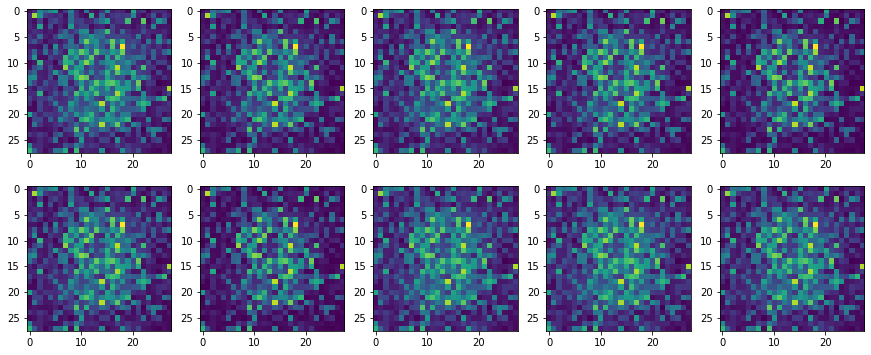

In [ ]:
import numpy as np

noise = tf.random.normal([10,100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  plt.imshow(output[i-1])

500 epoch 학습한 가중치 가져오기

In [ ]:
#!mkdir /content/drive/MyDrive/aiffel/conditional_generation/gan
#!wget -P /content/drive/MyDrive/aiffel/conditional_generation/gan https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip

In [ ]:
#!unzip /content/drive/MyDrive/aiffel/conditional_generation/gan/GAN_500.zip -d /content/drive/MyDrive/aiffel/conditional_generation/gan/

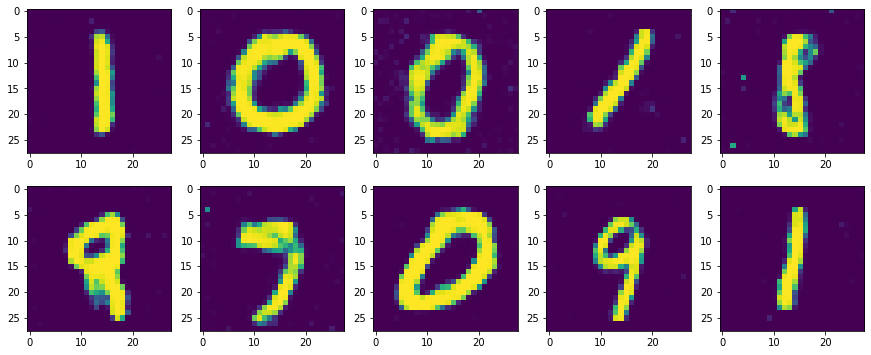

In [ ]:
import os
weight_path = '/content/drive/MyDrive/aiffel/conditional_generation/gan/GAN_500/GAN_500'

noise = tf.random.normal([10,100])

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  plt.imshow(output[i-1])


내가 원하는 특정 숫자 하나를 출력하기 위해 cGAN을 학습시켜보자

In [ ]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
  noise = tf.random.normal([real_images.shape[0], 100])

  with tf.GradientTape(persistent=True) as tape:
    fake_images = cgan_generator(noise, labels)#Generator를 이용해 가짜 이미지 생성
    
    real_out = cgan_discriminator(real_images, labels)
    fake_out = cgan_discriminator(fake_images, labels)#Discriminator를 이용해 진짜가짜 이미지 판별

    gene_loss = generator_loss(fake_out)
    disc_loss = discriminator_loss(real_out, fake_out) #각 손실을 계산
  
  gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
  disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables) #gradient 계산

  gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
  disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))

  return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
  for i ,(images,labels) in enumerate(cgan_datasets):
    gene_loss, disc_loss = cgan_step(images, labels)

    if (i+1) % 100 == 0:
      print(f'[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}')

[1/1 EPOCHS, 99 ITER] G:6.248675346374512, D:0.006139889359474182
[1/1 EPOCHS, 199 ITER] G:5.465336799621582, D:0.029627900570631027
[1/1 EPOCHS, 299 ITER] G:4.98380184173584, D:0.019139543175697327
[1/1 EPOCHS, 399 ITER] G:7.041709899902344, D:0.005215915851294994


500 epoch 학습한 가중치

In [ ]:
#!mkdir /content/drive/MyDrive/aiffel/conditional_generation/cgan
#!wget -P /content/drive/MyDrive/aiffel/conditional_generation/cgan https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
#!unzip /content/drive/MyDrive/aiffel/conditional_generation/cgan/CGAN_500.zip -d /content/drive/MyDrive/aiffel/conditional_generation/cgan/

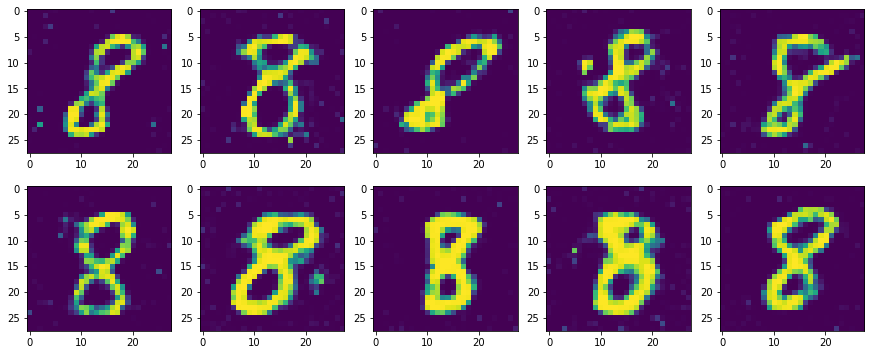

In [ ]:
number = 8

weight_path = '/content/drive/MyDrive/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10,100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  plt.imshow(output[i-1])


##pix2pix(image to image translation)
입력 자체가 조건이 된다!

이미지를 입력으로하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN모델

GAN, cGAN은 dense 레이어를 연속적으로 쌓아 만들었지만,

이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용

###encoder-decoder
입력이미지와 출력이미지의 크기가 동일해야한다

흔히 사용되는 구조는 encoder-decoder 구조

encoder는 이미지를 입력 받으면 단계적으로 down-sampling하면서 이미지의 중요한 representation을 학습

decoder는 반대로 up=sampling하여 입력 이미지와 동일한 크기의 변환된 이미지를 생성


###U-Net

encoder의 최종 출력인 bottleneck은 가장 중요한 feature만 담고 있는데 과연 변환된 이미지를 생성하는데 충분한 정보를 제공할까?

이를 보완하기 위해 제안된 Geenerator 구조가 바로 U-Net

generator(encoder-decoder)와 손실함수(L1,L2)만 가지고도 이미지를 생성할 수 있지 않나 싶지만

실제로 L1 + cGAN을 사용한 것이 결과가 제일 좋았다

###pix2pix의 discriminator

1. pix2pix는 DCGAN과는 다르게 최종 결과가 여러개 값을 갖는다

2. 입력 이미지의 전체 영역을 다 보는 것이 아닌 일부 영역에 대해서만 진짜 가짜를 판별하는 확률값을 도출

3. 이 값들을 평균하여 최종 discriminator 출력을 생성한다

4. 이런 방법은 일부 영역(patch)을 이용한다 해서 patchGAN이라고 불림

5. 이미지에서 거리가 먼 픽셀을 서로 연관성이 거의 없기 떄문에,
특정 크기를 가진 일부 영역에 대해서 진짜/가짜 판별하여 더 진짜같은 이미지를 생성해 내는 것

In [ ]:
#!mkdir /content/drive/MyDrive/aiffel/conditional_generation/data
#!wget -P /content/drive/MyDrive/aiffel/conditional_generation/data https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip

In [ ]:
#!unzip /content/drive/MyDrive/aiffel/conditional_generation/data/sketch2pokemon.zip -d /content/drive/MyDrive/aiffel/conditional_generation/data

os.dir() 메서드는 디렉토리 내 모든 파일과 디렉토리를 리스트로 리턴한다.

경로 지정하지 않으면 현재의 working directory를 사용한다.

In [ ]:
data_path = '/content/drive/MyDrive/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print('number of train example: ', len(os.listdir(data_path)))

number of train example:  830


학습용 데이터셋 확인

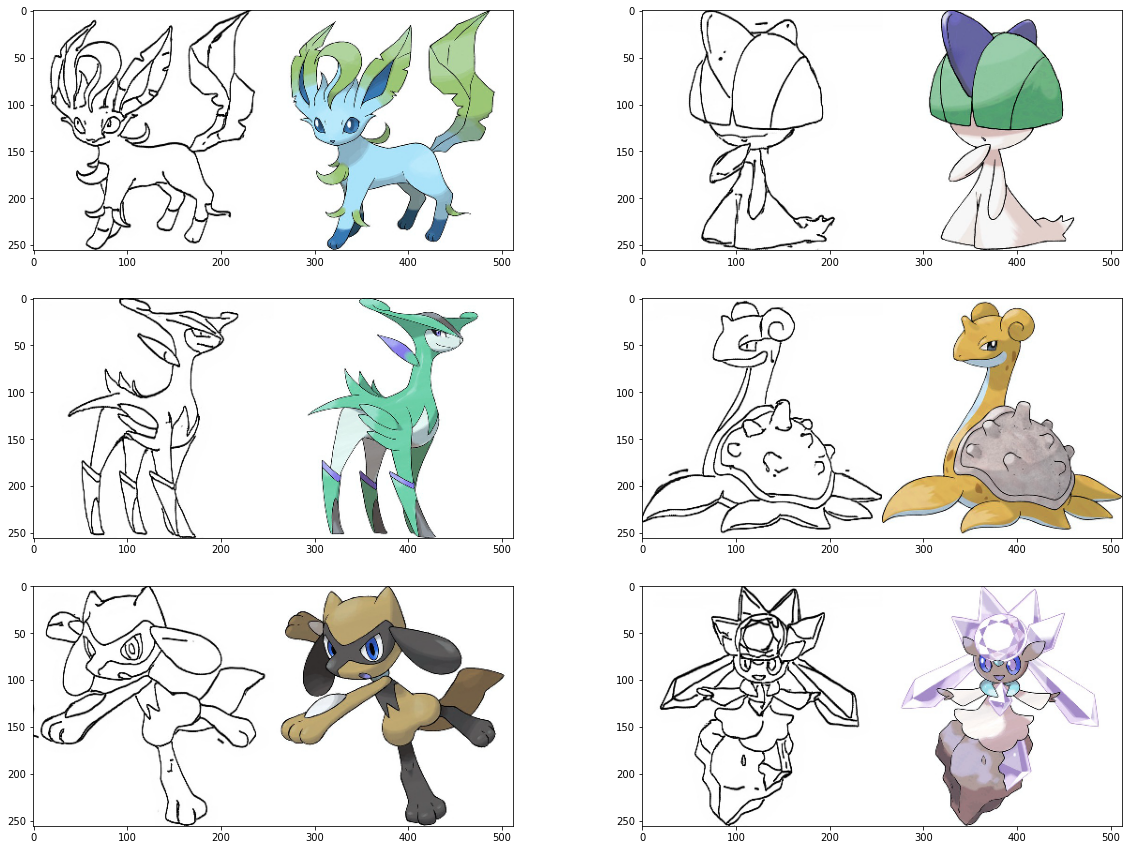

In [ ]:
import cv2

plt.figure(figsize=(20,15))
for i in range(1,7):
  f = data_path + os.listdir(data_path)[np.random.randint(800)]
  img = cv2.imread(f, cv2.IMREAD_COLOR)
  plt.subplot(3,2,i)
  plt.imshow(img)

- 이미지 읽기의 flag

cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.

cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.

cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.

3개의 flag대신에 1, 0, -1을 사용해도 됩니다.

https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html


직접 그린게 아닌 스케치 생성모델을 이용했다고 한다!

In [ ]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


학습에 사용할 데이터를 (256,256,3) 크기의 2개 이미지로 분할해서 사용

uint8

2^8개의 부호없는 정수표현 가능. 0에서 255까지. 그레이스케일 또는 3채널 컬러 이미지를 담을 때 많이 사용됩니다. 

normalize 에는 float32를

denormalize 에는 unit8을 사용했다

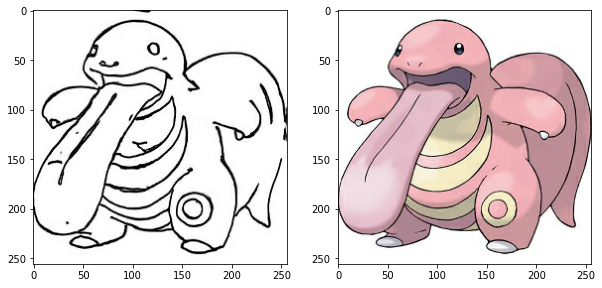

In [ ]:
def normalize(x):
  x = tf.cast(x, tf.float32) # 데이터 타입 바꾸기
  return(x/127.5) -1

def denormalize(x):
  x = (x+1)*127.5
  x = x.numpy()
  return x.astype(np.uint8)

def load_img(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img, 3) #3은 채널 수인 듯

  w = tf.shape(img)[1] // 2
  sketch = img[:, :w, :]
  sketch = tf.cast(sketch, tf.float32)
  colored = img[:, w:, :]
  colored = tf.cast(colored, tf.float32)
  return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))





스케치를 입력하여 채색된 이미지를 생성하는 것이 목표

###augmentation

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() #빠른 텐서플로 연산을 위해
def apply_augmentation(sketch, colored):
  stacked = tf.concat([sketch, colored], axis=-1) # 두 이미지가 채널 축으로 연결 >> 6채널이 된다

  _pad = tf.constant([[30,30], [30,30], [0,0]])
  if tf.random.uniform(()) < .5: #50%의 확률
    padded = tf.pad(stacked, _pad, 'REFLECT') #_pad 행렬로 만들 때 패딩주기
  else:
    padded = tf.pad(stacked, _pad, 'CONSTANT', constant_values = 1.)
  
  out = image.random_crop(padded, size=[256,256,6])

  out = image.random_flip_left_right(out)
  out = image.random_flip_up_down(out)

  if tf.random.uniform(()) < .5:
    degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
    out = image.rot90(out, k=degree) #이미지를 시계 반대 방향으로 90도 회전합니다.

  return out[...,:3], out[...,3:]


1. 50%의 확률로 30픽셀의 pad_width만큼 패딩
2. 1의 결과를 임의로 잘라냄
3. 2의 결과를 임의로 가로로 뒤집
4. 3의 결과를 임의로 세로로 뒤집
5. 4의 결과를 50%확률로 회전

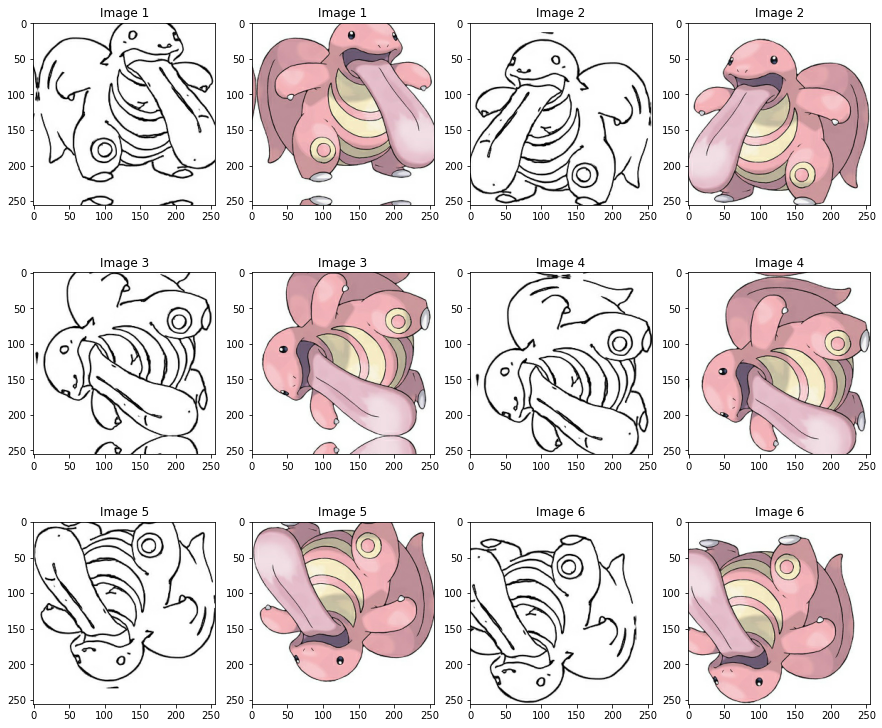

In [ ]:
plt.figure(figsize=(15,13))

img_n = 1

for i in range(1, 13, 2):
  augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)

  plt.subplot(3,4,i)
  plt.imshow(denormalize(augmented_sketch)); plt.title(f'Image {img_n}')
  plt.subplot(3,4,i+1)
  plt.imshow(denormalize(augmented_colored)); plt.title(f'Image {img_n}')
  img_n += 1

위 과정들을 학습 데이터에 적용

잘 적용되었는지 이미지 하나만 확인

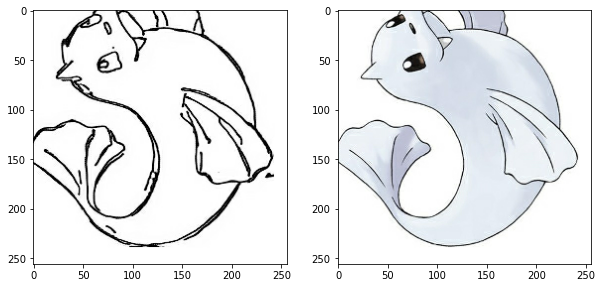

In [ ]:
from tensorflow import data

def get_train(img_path):
  sketch, colored = load_img(img_path)
  sketch, colored = apply_augmentation(sketch, colored)
  return sketch, colored

train_images = data.Dataset.list_files(data_path + '*.jpg')
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0] + 1)*127.5, (sample[0][1] + 1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

###pix2pix 구현

Generator의 Encoder Decoder를 만들자

Conv > Batchnorm > LeakyReLu 3개의 레이어로 구성된 기본적인 블록 생성

[pix2pix 구조](https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png)

In [ ]:
from tensorflow.keras import layers,Input, Model

class EncodeBlock(layers.Layer):
  def __init__(self, n_filters, use_bn=True):
    super(EncodeBlock, self).__init__()
    self.use_bn = use_bn
    self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
    self.batchnorm = layers.BatchNormalization()
    self.lrelu = layers.LeakyReLU(0.2)

  def call(self, x):
    x = self.conv(x)
    if self.use_bn:
      x = self.batchnorm(x)
    return self.lrelu(x)

use_bn 을 설정해서 batchnorm 사용 여부를 결정할 수 있다

필터의 크기 (=4), stride(=2), leakReLu 활성화의 slope coefficient(=0.2)는 고정임으로 값을 지정했다



In [ ]:
class Encoder(layers.Layer):
  def __init__(self):
    super(Encoder, self).__init__()
    filters = [64, 128, 256, 512, 512, 512, 512, 512]

    self.blocks = []
    for i, f in enumerate(filters):
      if i ==0:
        self.blocks.append(EncodeBlock(f, use_bn=False))
      else:
        self.blocks.append(EncodeBlock(f))

  def call(self, x):
    for block in self.blocks:
      x = block(x)
    return x

  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

In [ ]:
Encoder().get_summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encode_block_48 (EncodeBloc  (None, 128, 128, 64)     3072      
 k)                                                              
                                                                 
 encode_block_49 (EncodeBloc  (None, 64, 64, 128)      131584    
 k)                                                              
                                                                 
 encode_block_50 (EncodeBloc  (None, 32, 32, 256)      525312    
 k)                                                              
                                                                 
 encode_block_51 (EncodeBloc  (None, 16, 16, 512)      2099200   
 k)                                                        

###Decoder

In [ ]:
class DecodeBlock(layers.Layer):
  def __init__(self, f, dropout=True):
    super(DecodeBlock, self).__init__()
    self.dropout = dropout
    self.Transconv = layers.Conv2DTranspose(f, 4, 2, 'same', use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.relu = layers.ReLU()

  def call(self,x):
    x = self.Transconv(x)
    x = self.batchnorm(x)
    if self.dropout:
      x = layers.Dropout(.5)(x)

    return self.relu(x)

class Decoder(layers.Layer):
  def __init__(self):
    super(Decoder, self).__init__()
    filters = [512,512,512,512,256,128,64]

    self.blocks = []
    for i, f in enumerate(filters):
      if i < 3:
        self.blocks.append(DecodeBlock(f))
      else:
        self.blocks.append(DecodeBlock(f, dropout = False))

    self.blocks.append(layers.Conv2DTranspose(3,4,2, 'same',use_bias=False))

  def call(self,x):
    for block in self.blocks:
      x = block(x)
    return x

  def get_summary(self, input_shape=(1,1,512)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()           

처음 세 개 블록에서만 Dropout 사용

마지막 conv 에서는 3개 필터 사용

In [ ]:
Decoder().get_summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 1, 512)]       0         
                                                                 
 decode_block_56 (DecodeBloc  (None, 2, 2, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_57 (DecodeBloc  (None, 4, 4, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_58 (DecodeBloc  (None, 8, 8, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_59 (DecodeBloc  (None, 16, 16, 512)      4196352   
 k)                                                        

위에 구성한 encoder decoder를 연결해서 genoerator를 구성하자

(256,256,3) > (1,1,512) > (256,256,3)



In [ ]:
class EncoderDecoderGenerator(Model):
  def __init__(self):
    super(EncoderDecoderGenerator, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def call(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

EncoderDecoderGenerator().get_summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encoder_3 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_5 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


##U-Net 구조

- __init__ 에 정의된 encode_block decode_block 가 차례대로 사용되어 내부 연산 수행

- 이떄 encoder decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 encoder 내에 사용된 각 블록들의 출력을 차려대로 담음

- encoder의 최종 출력이 decoder의 입력으로 들어감

- features 리스트 인자들이 decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용

In [ ]:
class UNetGenerator(Model):
  def __init__(self):
    super(UNetGenerator, self).__init__()
    encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
    decode_filters = [512, 512, 512, 512, 256, 128, 64]

    self.encode_blocks = []
    for i, f in enumerate(encode_filters):
      if i == 0:
        self.encode_blocks.append(EncodeBlock(f, use_bn = False))
      else:
        self.encode_blocks.append(EncodeBlock(f))

    self.decode_blocks = []
    for i, f in enumerate(decode_filters):
      if i < 3:
        self.decode_blocks.append(DecodeBlock(f))
      else:
        self.decode_blocks.append(DecodeBlock(f, dropout = False))

    self.last_conv = layers.Conv2DTranspose(3,4,2,'same', use_bias=False)

  def call(self, x):
    features = [] # encode_block 수행할 때마다 결과물 저장 > skip connection 에 쓸 것임
    for block in self.encode_blocks:
      x = block(x)
      features.append(x)

    features = features[:-1] #맨 마지막 결과물은 어차피 입력으로 들어가니까 필요없음

    for block, feat in zip(self.decode_blocks, features[::-1]): #features를 역순으로 넣는다
      x = block(x)
      x = layers.Concatenate()([x,feat])

    x = self.last_conv(x)
    return x

  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()



In [ ]:
'''class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
'''

'class UNetGenerator(Model):\n    def __init__(self):\n        super(UNetGenerator, self).__init__()\n        encode_filters = [64,128,256,512,512,512,512,512]\n        decode_filters = [512,512,512,512,256,128,64]\n        \n        self.encode_blocks = []\n        for i, f in enumerate(encode_filters):\n            if i == 0:\n                self.encode_blocks.append(EncodeBlock(f, use_bn=False))\n            else:\n                self.encode_blocks.append(EncodeBlock(f))\n        \n        self.decode_blocks = []\n        for i, f in enumerate(decode_filters):\n            if i < 3:\n                self.decode_blocks.append(DecodeBlock(f))\n            else:\n                self.decode_blocks.append(DecodeBlock(f, dropout=False))\n        \n        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)\n    \n    def call(self, x):\n        features = []\n        for block in self.encode_blocks:\n            x = block(x)\n            features.append(x)\n       

In [ ]:
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_80 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 encode_block_81 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_80[0][0]']        
                                                                                            

###Discriminator

- custom_pad: 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정
- act: 활성화 함수 사용 여부

In [ ]:
class DiscBlock(layers.Layer):

    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

출력의 크기를 1씩 감소시키는 방법

In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_88 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_179 (Ba  (None, 127, 127, 64)     256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_88 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainabl

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_19 (Concatenate)   (None, 256, 256, 6)  0           ['input_17[0][0]',               
                                                                  'input_18[0][0]']        

시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 (30,30)이 나오는지 확인

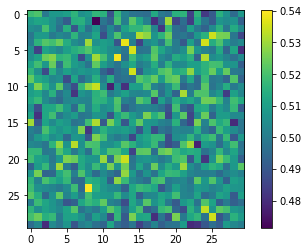

In [ ]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x,y)
plt.imshow(disc_out[0,...,0])
plt.colorbar()

입력 크기가 (256,256)이므로 (70,70) 패치는 많이 겹쳐있을 것

각각 픽셀 값은 sigmoid 함수의 결괏삾이므로 0~1 사이의 값을 갖고 진짜 가짜 데이터를 판별하는데 쓰인다

##모델 학습

gan 손실함수에 L1을 추가로 이용했을 때가 결과가 가장 좋았다

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

generator 손실함수

- fake_disc는 generator가 생성한 가짜이미지를 discriminator에 입력하여 얻어진 값 > 실제 이미지를 뜻하는 1 과 비교하기 위해 ones_like을 이용

- L1 손실을 계산하기 위해 fake_out 과 real_output 사이의 MAE를 계산


discriminator 손실함수

- 입력 값들은 진짜 가짜 이미지가 discriminator에 각각 입력되어 얻어진 값

- 실제 이미지를 잘 구분해 내야하므로 real_disc는 '1'로 채워진 벡터와 비교, fake_disc는 '0'으로 채워진 벡터와 비교

In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

하나의 배치 크기만큼 입력했을 때 가중치를 1회 업데이트하는 과정 

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.1407                     
L1_loss:0.4727                     
Discriminator_loss:1.0964

EPOCH[1] - STEP[20]                     
Generator_loss:1.0391                     
L1_loss:0.3781                     
Discriminator_loss:1.3320

EPOCH[1] - STEP[30]                     
Generator_loss:0.9483                     
L1_loss:0.2581                     
Discriminator_loss:1.1647

EPOCH[1] - STEP[40]                     
Generator_loss:1.5782                     
L1_loss:0.2025                     
Discriminator_loss:1.2215

EPOCH[1] - STEP[50]                     
Generator_loss:1.0427                     
L1_loss:0.2720                     
Discriminator_loss:0.8767

EPOCH[1] - STEP[60]                     
Generator_loss:2.2174                     
L1_loss:0.2557                     
Discriminator_loss:0.6402

EPOCH[1] - STEP[70]                     
Generator_loss:2.3404                     
L1_loss:0.2320                    

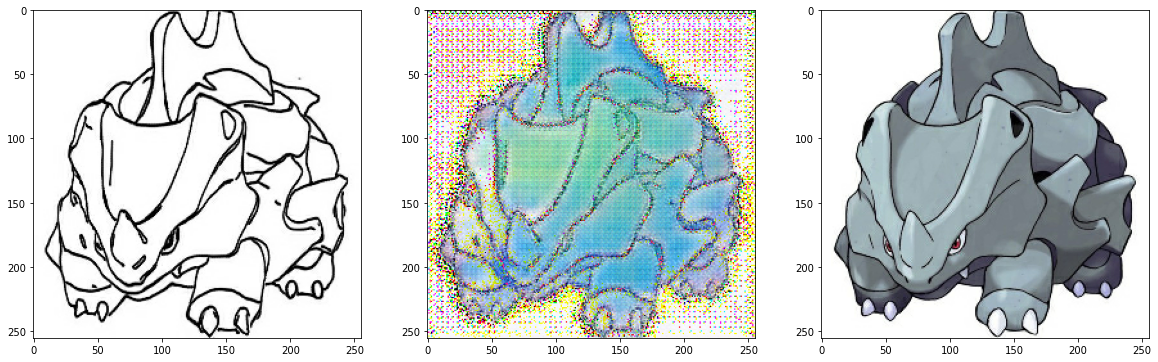

In [ ]:
test_ind = 11

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

포켓몬 수가 너무 많아 좋은 결과가 안 나온 것 같다. 